In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
from scipy.optimize import curve_fit
from collections import defaultdict
from scipy.spatial.distance import cdist
mpl.rcParams['axes.linewidth'] = 2
from DEPENDENCIES.recycle import *

In [2]:
def read_text_xy(fname, tini=0, tfin=1000000):
    f = open(fname, "r")
    fl = f.readlines()
    f.close()
    xy = []
    time = -1
    for line in fl:
        if "#T - >" in line:
            time = float(line.split()[3])
        elif time >= tini and time <= tfin:
            if "#" not in line and "@" not in line:
                xy.append(line.split()[:2])
    xy = np.array(xy, dtype='float')
    print("Done with {}".format(fname))
    return xy

def bootstrap_xy_map(xy, n_res=50, L=12, boot_size=50000, boot_iter=5000):
    np.random.seed(666)
    pt_ndxs = np.linspace(0,len(xy)-1, len(xy), dtype='int')
    boots = []
    for i in range(boot_iter):
        boot_ndxs = np.random.choice(pt_ndxs, size=boot_size, replace=True)
        boot_pts = xy[boot_ndxs]
        #xmin, xmax = np.min(boot_pts[:,0]), np.max(boot_pts[:,0])
        #ymin, ymax = np.min(boot_pts[:,1]), np.max(boot_pts[:,1])
        #H, xedges, yedges = np.histogram2d(*boot_pts.T, density=True, bins=n_res, range=[[xmin, xmax], [ymin, ymax]])
        H, xedges, yedges = np.histogram2d(*boot_pts.T, density=True, bins=n_res, range=[[0, L], [0, L]])
        boots.append(H)
    boots = np.array(boots)*324#chol molecules
    boot_mean = np.mean(boots, axis=0)
    boot_std = np.std(boots, axis=0)
    return boot_mean, boot_std 

In [4]:
p6_chol_xy = read_text_xy("CHOL/POPC6-35_PRO1_chol_xy.sfu", tini=0, tfin=1000000)
g6_chol_xy = read_text_xy("CHOL/gH-POPC6-46_PRO1_chol_xy.sfu", tini=50000, tfin=1000000)
n06_chol_xy = read_text_xy("CHOL/NP610-POPC6-46_PRO1_chol_xy.sfu", tini=215000, tfin=1000000)
n161_chol_xy = read_text_xy("CHOL/NP61-POPC6-46_PRO1_chol_xy.sfu", tini=126000, tfin=864000)
n162_chol_xy = read_text_xy("CHOL/NP61-POPC6-46_PRO1_chol_xy.sfu", tini=864000, tfin=1000000)

Done with CHOL/NP610-POPC6-46_PRO1_chol_xy.sfu


In [5]:
p6_chol, p6_chol_std = bootstrap_xy_map(p6_chol_xy, L=12)
g6_chol, g6_chol_std = bootstrap_xy_map(g6_chol_xy, L=12)
n06_chol, n06_chol_std = bootstrap_xy_map(n06_chol_xy, L=12)
n161_chol, n161_chol_std = bootstrap_xy_map(n161_chol_xy, L=12)
n162_chol, n162_chol_std = bootstrap_xy_map(n162_chol_xy, L=12)

In [6]:
print("POPC:CHOL")
average_map(p6_chol, 1000) #1000 to grab the whole grid
average_map(p6_chol_std, 1000) #1000 to grab the whole grid
print("POPC:CHOL -> gH-local")
average_map(g6_chol, 6)#6 pixels is 1.56 nm
average_map(g6_chol_std, 6)#6 pixels is 1.56 nm
print("POPC:CHOL -> NP0-local")
average_map(n06_chol, 6)#6 pixels is 1.56 nm
average_map(n06_chol_std, 6)#6 pixels is 1.56 nm
print("POPC:CHOL -> gHNP-local (Binding mode 1)")
average_map(n161_chol, 6)#6 pixels is 1.56 nm
average_map(n161_chol_std, 6)#6 pixels is 1.56 nm
print("POPC:CHOL -> gHNP-local (Binding mode 2)")
average_map(n162_chol, 6)#6 pixels is 1.56 nm
average_map(n162_chol_std, 6)#6 pixels is 1.56 nm

POPC:CHOL
2.25 +/- 0.12
0.526 +/- 0.015
POPC:CHOL -> gH-local
2.247 +/- 0.236
0.525 +/- 0.029
POPC:CHOL -> NP0-local
1.938 +/- 1.248
0.468 +/- 0.132
POPC:CHOL -> gHNP-local (Binding mode 1)
2.236 +/- 0.309
0.523 +/- 0.036
POPC:CHOL -> gHNP-local (Binding mode 2)
2.054 +/- 1.031
0.494 +/- 0.12


In [7]:
def plot_chol(chol, mean=2.25, delta=0.5, cmap='bwr', fname='tmp'):
    fig, ax = plt.subplots(figsize=(3.5,3.5), subplot_kw={'xticks':[0,24,49], 'yticks':[0,24,49], 'xticklabels':['-7.0','0.0','+7.0'], 'yticklabels':['+7.0','0.0','-7.0']}, gridspec_kw={'wspace':0.4})
    ax.tick_params(labelsize=Z)
    ax.set_xlabel("X-axis (nm)", fontsize=Z)
    ax.set_ylabel("Y-axis (nm)", fontsize=Z)
    cax = ax.imshow(chol, cmap=cmap, vmin=mean-delta, vmax=mean+delta, interpolation='bilinear')

    a = plt.axes([1., 0.135, 0.06, 0.75])
    cbar = fig.colorbar(cax, ax=a, cax=a, ticks=[mean-delta,mean,mean+delta])
    cbar.ax.set_yticklabels(["{:.1f}".format(mean-delta), "{:.1f}".format(mean), "{:.1f}".format(mean+delta)])
    cbar.ax.tick_params(labelsize=Z)
    cbar.ax.set_ylabel("Probability density ($nm^{-2}$)", fontsize=Z-2)
    plt.savefig("Plots/{}_chol.png".format(fname), format='png', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()
    plt.close()

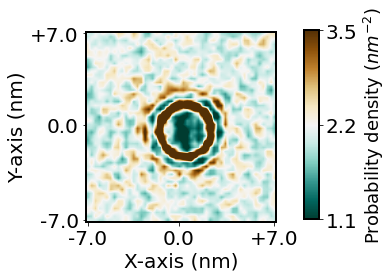

In [8]:
plot_chol(n06_chol, cmap='BrBG_r', delta=1.2, fname="NP0")

In [76]:
def xy_to_radial(xy, L=12, rbins=50, boot_iter=1000, boot_size=5000):
    dxy = xy - L/2.0
    rs = np.linalg.norm(dxy, axis=1)
    rs = rs[rs<L/2.0]

    np.random.seed(666)
    pt_ndxs = np.linspace(0,len(rs)-1, len(rs), dtype='int')
    boots = []
    for i in range(boot_iter):
        boot_ndxs = np.random.choice(pt_ndxs, size=boot_size, replace=True)
        boot_pts = rs[boot_ndxs]
        hist, bins = np.histogram(boot_pts, bins=rbins, range=[0, L/2])
        hist = hist/(2*np.pi*bins[1:]*(bins[1]-bins[0]))
        boots.append(hist)
    boots = np.array(boots)#*324#chol molecules
    boot_mean = np.mean(boots, axis=0)
    boot_std = np.std(boots, axis=0)
    return 0.5*(bins[1:]+bins[:-1]), boot_mean, boot_std 
    
p6_chol_r = xy_to_radial(p6_chol_xy)
n06_chol_r = xy_to_radial(n06_chol_xy)
#print(n06_chol_xy.shape)

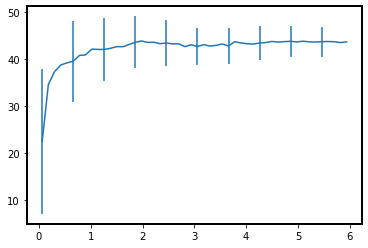

In [72]:
fig = plt.figure()
ax = plt.axes()
ax.errorbar(p6_chol_r[0], p6_chol_r[1], yerr=p6_chol_r[2], errorevery=5)
plt.show()
plt.close()

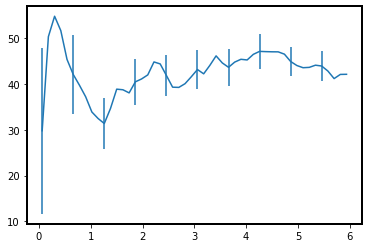

In [74]:
fig = plt.figure()
ax = plt.axes()
ax.errorbar(n162_chol_r[0], n162_chol_r[1], yerr=n162_chol_r[2], errorevery=5)
plt.show()
plt.close()

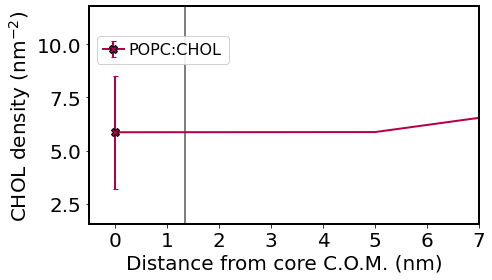

In [75]:
every = 1
fig = plt.figure(figsize=(7,4))
ax = plt.axes()
ax.set_xlim(-0.5,7)
#ax.set_ylim(3.5,5.5)
ax.set_xticks(range(8))
ax.tick_params(labelsize=Z)
ax.set_xlabel("Distance from core C.O.M. (nm)", fontsize=Z)
ax.set_ylabel(r"CHOL density (nm$^{-2}$)", fontsize=Z)
#ax.fill_between([-0.5,7],3.975-0.184, 3.975+0.184, color=(0.2,0.7,0.7), alpha=0.1)
#ax.fill_between([-0.5,7],4.351-0.152, 4.351+0.152, color=(0.7,0.0,0.3), alpha=0.1)
ax.axvline(1.35, lw=2, c='k', alpha=0.5)
#ax.errorbar(*n05_thick_r[:2], yerr=n05_thick_r[2], mew=1.1, markevery=every, errorevery=every, fmt='-o', ms=8, lw=2, mec='k', color=(0.2,0.7,0.7), capsize=2.5, label='POPC')
ax.errorbar(*n06_chol_r[:2], yerr=n06_chol_r[2], mew=1.1, markevery=every+5, errorevery=every+5, fmt='-X', ms=8, lw=2, mec='k', color=(0.7,0.0,0.3), capsize=2.5, label='POPC:CHOL')
ax.legend(fontsize=Z-4, mode='expand', bbox_to_anchor=(0., 0.7,0.38,0.6), loc='lower left', framealpha=0.9, handletextpad=0.3, handlelength=1.3)
plt.savefig("Plots/NP0_thickr.png", format='png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()
plt.close()

In [95]:
print(np.sort(n06_chol, axis=0)[-1])
print(np.max(n06_chol))
print(np.where(n06_chol==np.max(n06_chol)))

[2.39652041 2.71483656 2.58141377 2.60211476 2.87378368 2.70256337
 2.68145442 2.65802772 2.83654416 2.82150785 2.8115221  2.76971479
 2.99483272 3.10161755 2.99608672 3.7284471  3.45721346 3.31895277
 4.28020711 6.87815926 7.33241603 6.83976662 6.00830375 6.70013222
 6.65364914 5.66594733 7.05948679 8.57942293 6.33527962 4.89295568
 5.80832104 7.43464523 6.66368913 3.63052406 3.7624501  3.40038693
 3.21553773 2.69700475 2.89097216 2.74220015 2.73698683 2.77085255
 2.67956196 2.41693204 2.79923333 2.81243506 2.80510175 2.58768694
 2.55681284 2.60561289]
8.57942292811381
(array([19], dtype=int64), array([27], dtype=int64))


POPC:CHOL


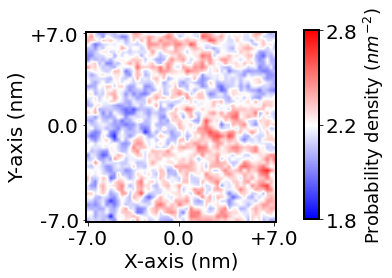

gH with cholesterol


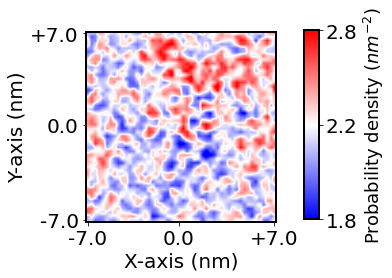

NP0 without cholesterol


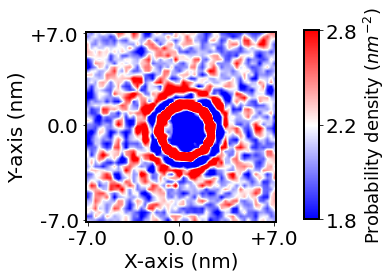

gHNP without cholesterol (Binding mode 1)


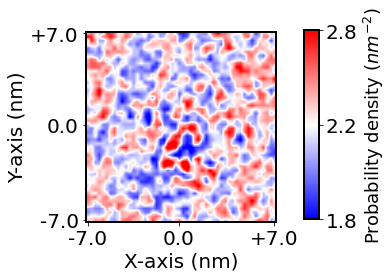

gHNP without cholesterol (Binding mode 2)


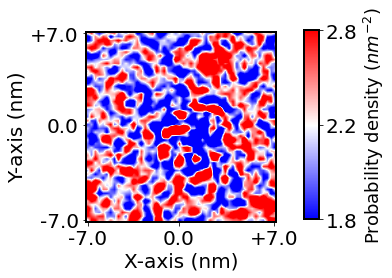

In [80]:
print("POPC:CHOL")
plot_chol(p6_chol)
print("gH with cholesterol")
plot_chol(g6_chol)
print("NP0 without cholesterol")
plot_chol(n06_chol)
print("gHNP without cholesterol (Binding mode 1)")
plot_chol(n161_chol)
print("gHNP without cholesterol (Binding mode 2)")
plot_chol(n162_chol)